# Vehicle Detection Project

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

### 1.1 Histogram of Oriented Gradients (HOG) feature extraction

### 1.1.1 Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


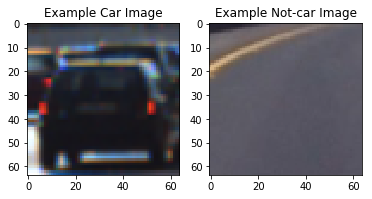

In [85]:
# data exploration

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

cars = glob.glob('images/vehicles/**/*.png')
notcars = glob.glob('images/non-vehicles/**/*.png')
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    image = mpimg.imread(car_list[0])
    data_dict["image_shape"] = image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

### 1.1.2 scikit-image HOG implementation

The scikit-image [hog( ) function](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog) takes in **a single color channel** or **grayscaled image** as input, as well as various parameters. These parameters include **orientations**, **pixels_per_cell** and **cells_per_block**. [Example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) of hog( ) function.

The number of **orientations** is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The **pixels_per_cell** parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The **cells_per_block** parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

There is another optional power law or "gamma" normalization scheme set by the flag **transform_sqrt**. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).

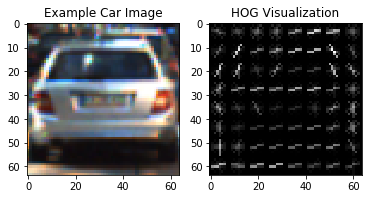

In [86]:
from skimage.feature import hog
    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

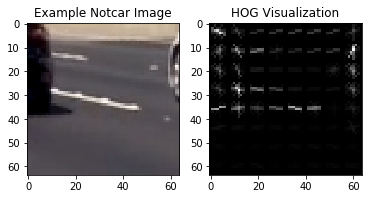

In [87]:
# HOG of not car:
# Generate a random index to look at a notcar image
ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Notcar Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

### 1.2 Train a Linear SVM classifier with the HOG features

### 1.2.1 Combine and Normalize Features

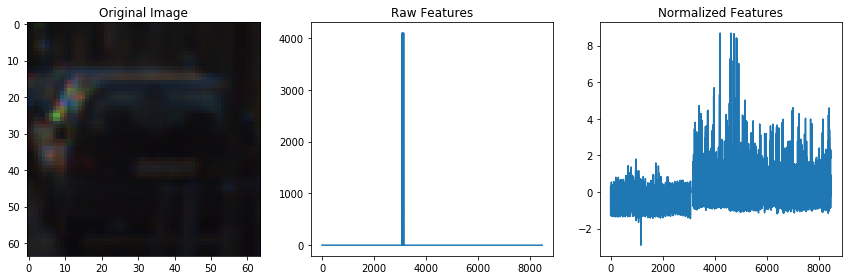

In [88]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

### 1.2.2 HOG Classify

In [89]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split


### Tweak these parameters and see how the results change.

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off



t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Features scaled to zero mean and unit variance before training the classifier.
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

55.23 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
32.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.00146 Seconds to predict 10 labels with SVC


## 2. Sliding Window Search

### 2.1 Sliding Window Implementation

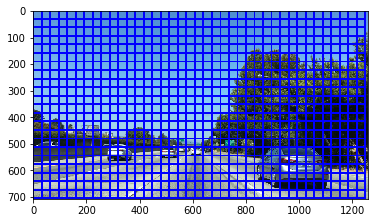

In [120]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')

# Here is the draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

### 2.2 Search and Classify

### 2.2.1 Necessary Methods

In [121]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### 2.2.2 Search and Classify

In [122]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction > 0.9:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


cars = glob.glob('images/vehicles/**/*.png')
notcars = glob.glob('images/non-vehicles/**/*.png')
### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
29.91 Seconds to train SVC...
Test Accuracy of SVC =  0.991


[ 64  96 128 160]
4.93 Seconds to find all the windows in the image


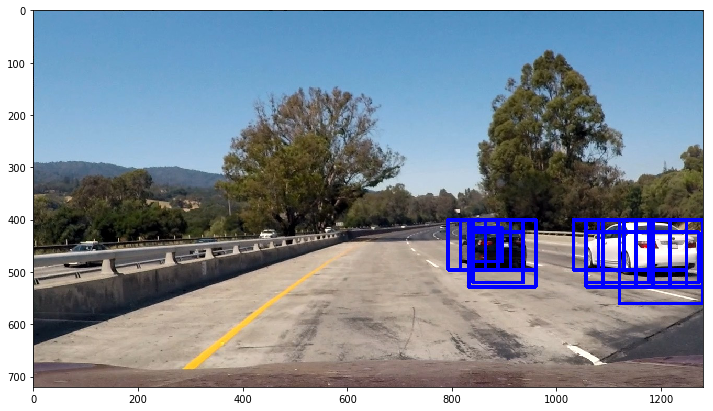

In [123]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

t=time.time()
xy_window=np.arange(2,6)*32
print(xy_window)
all_windows=[]
for window in xy_window:
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window, window), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    for xy in hot_windows:
        all_windows.append(xy)


window_img = draw_boxes(draw_image, all_windows, color=(0, 0, 255), thick=6) 
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find all the windows in the image')

fig = plt.figure(figsize=(12,12))
plt.imshow(window_img)
plt.show()

### 2.3 Multiple Detections & False Positives

In this part, build a heat-map from these detections in order to combine overlapping detections and remove false positives.

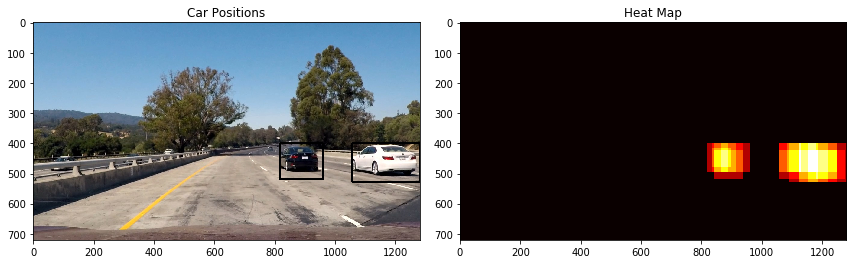

In [124]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


box_list = all_windows
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.show()

## 3. Video Implementation

### 3.1 Final Video Output

In [125]:
def process_image(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    xy_window=np.arange(2,6)*32
    all_windows=[]
    for window in xy_window:
    
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                               xy_window=(window, window), xy_overlap=(0.75, 0.75))

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, hog_feat=hog_feat)
        for xy in hot_windows:
            all_windows.append(xy)
    
    box_list = all_windows
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    return draw_img

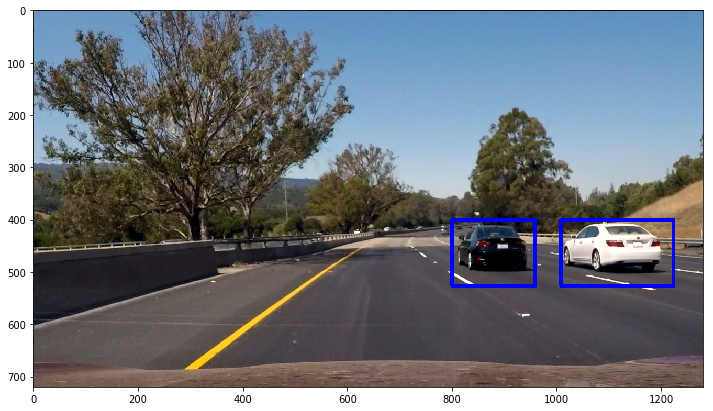

In [133]:
image = mpimg.imread('test_images/test6.jpg')
fig = plt.figure(figsize=(12,12))
plt.imshow(process_image(image))
plt.show()

In [134]:
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile('test_video_processed.mp4', audio=False)

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4



 97%|█████████▋| 38/39 [03:02<00:04,  4.88s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 

CPU times: user 3min 2s, sys: 60 ms, total: 3min 2s
Wall time: 3min 3s


In [136]:
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile('project_video_processed.mp4', audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:04<1:39:10,  4.72s/it]

  0%|          | 2/1261 [00:09<1:39:27,  4.74s/it]

  0%|          | 3/1261 [00:14<1:39:23,  4.74s/it]

  0%|          | 4/1261 [00:18<1:39:17,  4.74s/it]

  0%|          | 5/1261 [00:23<1:39:20,  4.75s/it]

  0%|          | 6/1261 [00:28<1:39:15,  4.75s/it]

  1%|          | 7/1261 [00:33<1:38:59,  4.74s/it]

  1%|          | 8/1261 [00:37<1:38:56,  4.74s/it]

  1%|          | 9/1261 [00:42<1:39:45,  4.78s/it]

  1%|          | 10/1261 [00:47<1:39:43,  4.78s/it]

  1%|          | 11/1261 [00:52<1:39:15,  4.76s/it]

  1%|          | 12/1261 [00:57<1:38:51,  4.75s/it]

  1%|          | 13/1261 [01:01<1:38:35,  4.74s/it]

  1%|          | 14/1261 [01:06<1:38:28,  4.74s/it]

  1%|          | 15/1261 [01:11<1:38:40,  4.75s/it]

  1%|▏         | 16/1261 [01:16<1:38:32,  4.75s/it]

  1%|▏         | 17/1261 [01:20<1:38:33,  4.75s/it]

  1%|▏         | 18/1261 [01:25<1:38:31,  4.76s/it]

  2%|▏     

 22%|██▏       | 274/1261 [21:50<1:18:07,  4.75s/it]

 22%|██▏       | 275/1261 [21:54<1:17:55,  4.74s/it]

 22%|██▏       | 276/1261 [21:59<1:18:19,  4.77s/it]

 22%|██▏       | 277/1261 [22:04<1:18:00,  4.76s/it]

 22%|██▏       | 278/1261 [22:09<1:17:56,  4.76s/it]

 22%|██▏       | 279/1261 [22:13<1:17:44,  4.75s/it]

 22%|██▏       | 280/1261 [22:18<1:17:55,  4.77s/it]

 22%|██▏       | 281/1261 [22:23<1:17:53,  4.77s/it]

 22%|██▏       | 282/1261 [22:28<1:17:46,  4.77s/it]

 22%|██▏       | 283/1261 [22:32<1:17:46,  4.77s/it]

 23%|██▎       | 284/1261 [22:37<1:17:54,  4.78s/it]

 23%|██▎       | 285/1261 [22:42<1:17:53,  4.79s/it]

 23%|██▎       | 286/1261 [22:47<1:17:41,  4.78s/it]

 23%|██▎       | 287/1261 [22:52<1:17:30,  4.77s/it]

 23%|██▎       | 288/1261 [22:56<1:17:40,  4.79s/it]

 23%|██▎       | 289/1261 [23:01<1:17:35,  4.79s/it]

 23%|██▎       | 290/1261 [23:06<1:18:02,  4.82s/it]

 23%|██▎       | 291/1261 [23:11<1:17:51,  4.82s/it]

 23%|██▎       | 292/1261 [2

 43%|████▎     | 547/1261 [43:28<56:46,  4.77s/it]

 43%|████▎     | 548/1261 [43:33<56:45,  4.78s/it]

 44%|████▎     | 549/1261 [43:38<56:56,  4.80s/it]

 44%|████▎     | 550/1261 [43:42<56:55,  4.80s/it]

 44%|████▎     | 551/1261 [43:47<56:56,  4.81s/it]

 44%|████▍     | 552/1261 [43:52<56:52,  4.81s/it]

 44%|████▍     | 553/1261 [43:57<56:54,  4.82s/it]

 44%|████▍     | 554/1261 [44:02<57:03,  4.84s/it]

 44%|████▍     | 555/1261 [44:07<57:03,  4.85s/it]

 44%|████▍     | 556/1261 [44:11<56:58,  4.85s/it]

 44%|████▍     | 557/1261 [44:16<56:57,  4.85s/it]

 44%|████▍     | 558/1261 [44:21<57:04,  4.87s/it]

 44%|████▍     | 559/1261 [44:26<57:22,  4.90s/it]

 44%|████▍     | 560/1261 [44:31<57:18,  4.91s/it]

 44%|████▍     | 561/1261 [44:36<57:30,  4.93s/it]

 45%|████▍     | 562/1261 [44:41<57:26,  4.93s/it]

 45%|████▍     | 563/1261 [44:46<57:18,  4.93s/it]

 45%|████▍     | 564/1261 [44:51<57:12,  4.92s/it]

 45%|████▍     | 565/1261 [44:56<57:07,  4.92s/it]

 45%|████▍  

 66%|██████▌   | 826/1261 [1:05:44<34:25,  4.75s/it]

 66%|██████▌   | 827/1261 [1:05:49<34:28,  4.77s/it]

 66%|██████▌   | 828/1261 [1:05:54<34:15,  4.75s/it]

 66%|██████▌   | 829/1261 [1:05:58<34:06,  4.74s/it]

 66%|██████▌   | 830/1261 [1:06:03<34:00,  4.74s/it]


 66%|██████▌   | 831/1261 [1:06:08<33:59,  4.74s/it]

 66%|██████▌   | 832/1261 [1:06:13<33:50,  4.73s/it]

 66%|██████▌   | 833/1261 [1:06:17<33:47,  4.74s/it]

 66%|██████▌   | 834/1261 [1:06:22<33:40,  4.73s/it]

 66%|██████▌   | 835/1261 [1:06:27<33:36,  4.73s/it]

 66%|██████▋   | 836/1261 [1:06:32<33:32,  4.73s/it]

 66%|██████▋   | 837/1261 [1:06:36<33:28,  4.74s/it]

 66%|██████▋   | 838/1261 [1:06:41<33:25,  4.74s/it]

 67%|██████▋   | 839/1261 [1:06:46<33:20,  4.74s/it]

 67%|██████▋   | 840/1261 [1:06:51<33:19,  4.75s/it]

 67%|██████▋   | 841/1261 [1:06:55<33:15,  4.75s/it]

 67%|██████▋   | 842/1261 [1:07:00<33:07,  4.74s/it]

 67%|██████▋   | 843/1261 [1:07:05<32:56,  4.73s/it]

 67%|██████▋   | 844/1261 [

 87%|████████▋ | 1096/1261 [1:27:15<13:21,  4.85s/it]

 87%|████████▋ | 1097/1261 [1:27:20<13:13,  4.84s/it]

 87%|████████▋ | 1098/1261 [1:27:25<13:06,  4.83s/it]

 87%|████████▋ | 1099/1261 [1:27:29<13:01,  4.82s/it]

 87%|████████▋ | 1100/1261 [1:27:34<12:56,  4.82s/it]

 87%|████████▋ | 1101/1261 [1:27:39<12:51,  4.82s/it]

 87%|████████▋ | 1102/1261 [1:27:44<12:46,  4.82s/it]

 87%|████████▋ | 1103/1261 [1:27:49<12:43,  4.83s/it]

 88%|████████▊ | 1104/1261 [1:27:54<12:40,  4.85s/it]

 88%|████████▊ | 1105/1261 [1:27:58<12:37,  4.86s/it]

 88%|████████▊ | 1106/1261 [1:28:03<12:30,  4.84s/it]

 88%|████████▊ | 1107/1261 [1:28:08<12:22,  4.82s/it]

 88%|████████▊ | 1108/1261 [1:28:13<12:19,  4.84s/it]

 88%|████████▊ | 1109/1261 [1:28:18<12:14,  4.83s/it]

 88%|████████▊ | 1110/1261 [1:28:23<12:17,  4.88s/it]

 88%|████████▊ | 1111/1261 [1:28:27<12:06,  4.84s/it]

 88%|████████▊ | 1112/1261 [1:28:32<11:56,  4.81s/it]

 88%|████████▊ | 1113/1261 [1:28:37<11:49,  4.79s/it]

 88%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 1h 40min 17s, sys: 2.02 s, total: 1h 40min 19s
Wall time: 1h 40min 19s


## 4. Discussion

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

**The first problem I faced with was the lack of proper training data. The data to train the model would not completely cover all possible circunstances. This causes untable when applying the sliding window method. So after training the model with more car and non-car data, the result became better.**

**The second problem is how to choose a best series of sliding window sizes. Due to perspective projection, the car nearer to the camera looks bigger and  one that disappearing in the horizon is barely seen. Applying too many different sliding window sizes would both cost much more time and lower the degree of accuracy. So at last I chose a few reasonable sizes of sliding window.**

**My pipeline is likely to fail when two cars are very next to each other because of the heat map method. It would consider the two cars as one car when they seem as one heat point on the heat map figure. The make it more robust, more precise classifier is necessary to tell the differences when two or more cars are close to each other.**